In [281]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [282]:
using Interpolations
using Printf
using Optim
using PyPlot
using LinearAlgebra
using HDF5

In [283]:
function read_from_hdf5(h5file,obs_name)
	fid = h5open(h5file,"r")
	temps = fid["temperatures"][:]
	obs   = fid[obs_name*"/mean"]
	times = [i for i in 1:size(obs)[1]]
	return temps,obs,times
end

read_from_hdf5 (generic function with 1 method)

In [284]:
h5file = "2d_out.h5"
obs_name = "afvc_corr"
temps,m_data,times = read_from_hdf5(h5file,obs_name)

([0.8, 0.805, 0.81, 0.815, 0.82, 0.825, 0.83, 0.835, 0.84, 0.845  …  0.855, 0.86, 0.865, 0.87, 0.875, 0.88, 0.885, 0.89, 0.895, 0.9], HDF5.Dataset: /afvc_corr/mean (file: 2d_out.h5 xfer_mode: 0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001])

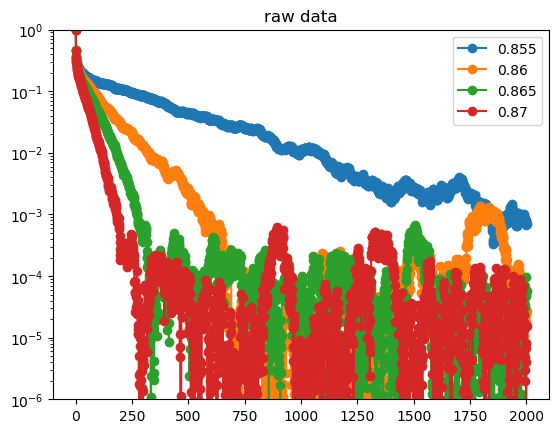

In [285]:
# cut too low temperature datas
num_temps = length(temps)
min_temp  = 12
max_temp  = 15
for it in min_temp:max_temp
	plt.semilogy(times,m_data[:,it],marker="o",label="$(temps[it])")
end
plt.title("raw data")
plt.ylim(1e-6,1)
plt.legend(loc="upper right")
plt.show()

In [286]:
for it in min_temp:max_temp
	println(temps[it])
end

0.855
0.86
0.865
0.87


In [287]:
#load average data from text file
temps = [0.855,0.860,0.865,0.870]
file_idx = [2,3,4,5]
num_temps = length(temps)
mc_steps  = 201
m_data = Array{Float64}(undef,mc_steps,num_temps)
counter = 1
for ifl in file_idx
	open("afvc_$(ifl)_ave.dat","r") do fp
		for is in 1:mc_steps
			str = split(readline(fp))
			m_data[is,counter] = parse(Float64,str[2])
		end
	end
	counter += 1
end

In [288]:
m_data

201×4 Array{Float64,2}:
 1.0       1.0        1.0         1.0
 0.471544  0.466857   0.461564    0.456667
 0.369917  0.362124   0.354491    0.346133
 0.327092  0.317127   0.30728     0.297108
 0.30302   0.291504   0.279845    0.267804
 0.286803  0.274324   0.261009    0.247265
 0.275448  0.261505   0.246633    0.232082
 0.26665   0.251557   0.235203    0.219863
 0.259225  0.243001   0.225955    0.209307
 0.253121  0.235771   0.217348    0.200244
 0.247819  0.229825   0.210342    0.192086
 0.243575  0.224319   0.203799    0.184454
 0.239255  0.219038   0.197307    0.17753
 ⋮                                
 0.107068  0.0415495  0.00820641  0.00091694
 0.106747  0.0412518  0.00795232  0.000886263
 0.106101  0.0406594  0.00779854  0.000850372
 0.106028  0.0403318  0.00771084  0.000768475
 0.105564  0.0399574  0.00756679  0.000774904
 0.105464  0.0395998  0.00743684  0.000747856
 0.104917  0.0390747  0.00723258  0.000722552
 0.104498  0.038941   0.00712444  0.000691333
 0.104191  0.038617  

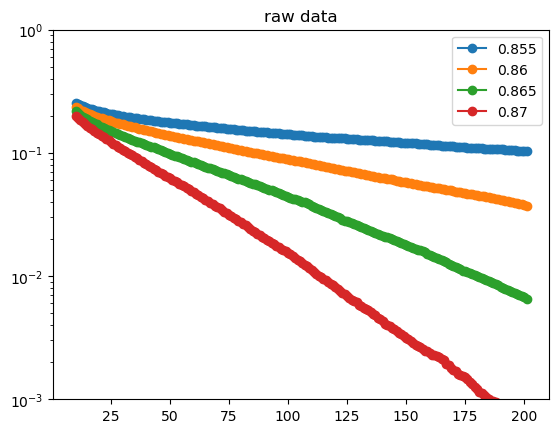

4


In [289]:
num_temps = length(temps)
println(num_temps)
times = [i for i in 1:size(m_data)[1]]
for it in 1:num_temps
	plt.semilogy(times[10:end],m_data[:,it][10:end],marker="o",label="$(temps[it])")
end
plt.title("raw data")
plt.ylim(1e-3,1)
plt.legend(loc="upper right")
plt.show()

In [290]:
# reshape some datas for optimization.
min_temp = 1
max_temp = 4
temps  = temps[min_temp:max_temp]
num_temps = length(temps)
m_data = m_data[:,min_temp:max_temp]


201×4 Array{Float64,2}:
 1.0       1.0        1.0         1.0
 0.471544  0.466857   0.461564    0.456667
 0.369917  0.362124   0.354491    0.346133
 0.327092  0.317127   0.30728     0.297108
 0.30302   0.291504   0.279845    0.267804
 0.286803  0.274324   0.261009    0.247265
 0.275448  0.261505   0.246633    0.232082
 0.26665   0.251557   0.235203    0.219863
 0.259225  0.243001   0.225955    0.209307
 0.253121  0.235771   0.217348    0.200244
 0.247819  0.229825   0.210342    0.192086
 0.243575  0.224319   0.203799    0.184454
 0.239255  0.219038   0.197307    0.17753
 ⋮                                
 0.107068  0.0415495  0.00820641  0.00091694
 0.106747  0.0412518  0.00795232  0.000886263
 0.106101  0.0406594  0.00779854  0.000850372
 0.106028  0.0403318  0.00771084  0.000768475
 0.105564  0.0399574  0.00756679  0.000774904
 0.105464  0.0395998  0.00743684  0.000747856
 0.104917  0.0390747  0.00723258  0.000722552
 0.104498  0.038941   0.00712444  0.000691333
 0.104191  0.038617  

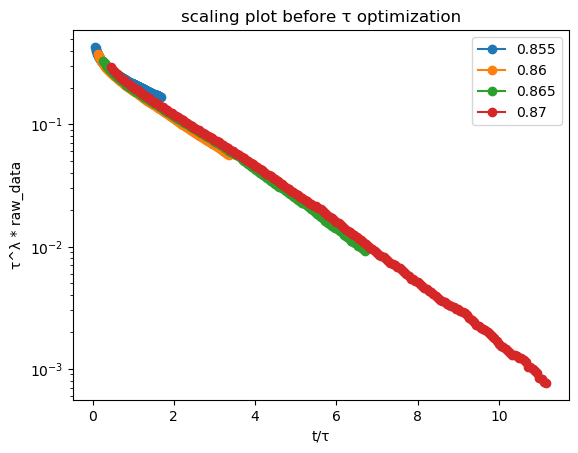

In [291]:
# search configuration of tau which put some curves on one curve.
taus   = [120.,60.,30.,18.0]
@assert length(taus) == max_temp - min_temp + 1
lambda = 0.1
start  = 8
plt.figure()
for it in 1:num_temps
	plt.semilogy(times[start:end] ./ taus[it],(taus[it]^lambda)*m_data[:,it][start:end],marker="o",label="$(temps[it])")
	
end
plt.title("scaling plot before τ optimization")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * raw_data")
plt.legend(loc="upper right")
plt.show()

In [292]:
"""
params: [tau1, tau2, ...]
"""
newaxis = [CartesianIndex()]
function cost(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[start] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    g_mean = sum(g_intpl, dims=2) ./ length(temps)
    norm(g_intpl .- g_mean[:, newaxis])^2 /  norm(g_mean)^2
end

cost (generic function with 1 method)

In [301]:
res = Optim.optimize(cost, taus)
res

fuck


In [294]:
taus_opt = Optim.minimizer(res)

4-element Array{Float64,1}:
 152.00430962693767
  54.97903837674394
  29.211209275078264
  19.593691749250716

In [295]:
for it in 1:length(temps)
	println("$(temps[it]) $(taus_opt[it])")
end


0.855 152.00430962693767
0.86 54.97903837674394
0.865 29.211209275078264
0.87 19.593691749250716


In [296]:
function mean(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[start] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    sum(g_intpl, dims=2) ./ length(temps)
end
g_mean = mean(taus_opt)

10×1 Array{Float64,2}:
 0.2838255119994568
 0.2620852882604657
 0.24470237386912336
 0.2296057359172264
 0.21661658517893842
 0.2046601389776334
 0.19408773470905716
 0.1838628612358235
 0.1751287424041376
 0.1662685077135777

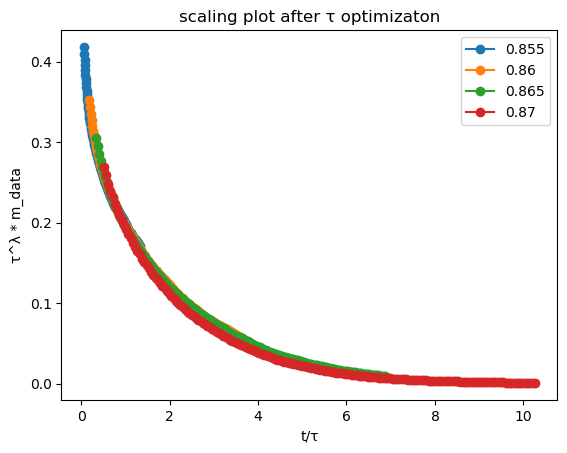

In [297]:
plt.figure
#taus_opt[4] = 17.5
for it in eachindex(temps)
	plt.plot(times[10:end] ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it][10:end], marker="o",label="$(temps[it])")
    #println((taus[it]^lambda) * m_data[:, it])
end
plt.title("scaling plot after τ optimizaton")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * m_data")
plt.legend(loc="upper right")
plt.show()

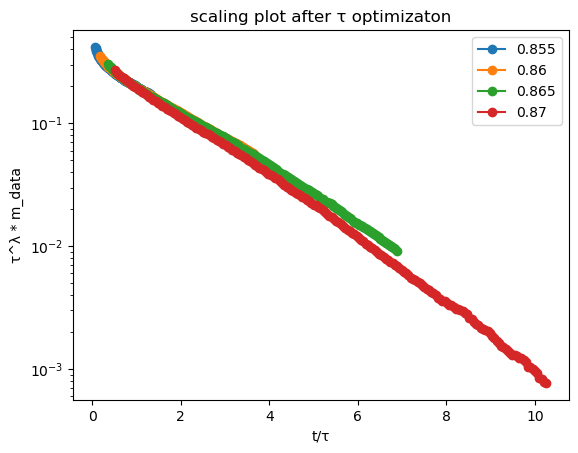

In [298]:
plt.figure
#taus_opt[4] = 17.5
for it in eachindex(temps)
	plt.semilogy(times[10:end] ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it][10:end], marker="o",label="$(temps[it])")
    #println((taus[it]^lambda) * m_data[:, it])
end
plt.title("scaling plot after τ optimizaton")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * m_data")
plt.legend(loc="upper right")
plt.show()

In [299]:
x = 1.0
y = 0.9
n = 100
test = range(x,y,length=n)

1.0:-0.00101010101010101:0.9

In [300]:
test = LinRange(x,y,n)


100-element LinRange{Float64}:
 1.0,0.99899,0.99798,0.99697,0.99596,…,0.90404,0.90303,0.90202,0.90101,0.9